In [19]:
import pandas as pd
from typing import Dict,List
from scr.pattern_detect import find_RoundingBottom
from scr.plotting import view_gride_chart

# 数据读取

- 时间范围:2014-01-01至2023-02-07
- 价格数据为后复权数据

In [3]:
data:pd.DataFrame = pd.read_csv('data/data.csv',index_col=[0,1],parse_dates=[0])

# 形态匹配

## 形态定义

1. 取当日向前追溯两年的股价数据进行**核回归**,根据核回归的结果找到所有局部极值点,对于每个极小值点$𝑃_{𝑙𝑜𝑤}$,找到其前面一个极大值点;
2. 在这个极大值点的邻域中(本文取前后20天范围内)找到股价序列的最大值,作为前一盘整区的高点,记为$𝑃_{ℎ𝑖𝑔ℎ}$，定义$𝑃_{ℎ𝑖𝑔ℎ}$到$𝑃_{𝑙𝑜𝑤}$的水平距离为圆弧的半弦长𝑑(要求𝑑大于10天);
3. 定义在$P_{𝑙𝑜𝑤}$前后𝑑天范围内的股价序列为s,收益率绝对值序列为r,检验是否满足圆弧底形态的条件:
   1. s在$P_{low}$左(右)侧下跌(上涨)的所占比例大于某一参数(本文取0.4);
   2. r的均值小于某一参数(本文取0.03);
   3. $(P_{ℎ𝑖𝑔ℎ}⁄P_{low} − 1)/𝑑$、$(P_{𝑏𝑢𝑦}⁄P_{low}− 1)/𝑑$小于某一参数(本文取0.03);
4. 若识别为圆弧底形态,则在s的右半部分寻找是否存在大于$P_{ℎ𝑖𝑔ℎ}$且已经突破200日均线的点,若存在,则将第一个突破$P_{ℎ𝑖𝑔ℎ}$的点作为买入点$𝑃_{𝑏𝑢𝑦}$。同时要求$(1 − p) ∗ (P_{ℎ𝑖𝑔ℎ} − 𝑃_{𝑙𝑜𝑤}) < 𝑃_{𝑏𝑢𝑦} − 𝑃_{𝑙𝑜𝑤} < (1 + p) ∗ (P_{ℎ𝑖𝑔ℎ} − 𝑃_{𝑙𝑜𝑤})$(本文中p取0.3);


**下面为出现圆弧底时对应的买入/卖出点**

5. 若开仓后的某日回归曲线中$𝑃_{𝑙𝑜𝑤}后面出现一个极大值点,则把当日作为卖出点$𝑃_{𝑠𝑒𝑙𝑙}$;
6. 如果下跌幅度超过10%则触发止损条件,卖出股票;
7. 对于其他极小值点-极大值点组合,重复上述过程。

除了找到极值点用到了核回归的结果,其他步骤用的都是实际的价格数据.

![avatar](img/%E7%A4%BA%E4%BE%8B.png)

**查找2023-02-07日当天符合圆弧底形态的股票**

In [7]:
output: Dict = {
    code: find_RoundingBottom(
        slice_df.reset_index(level=1, drop=True), code=code
    )
    for code, slice_df in data.groupby(level='code')
}

2023-03-01 14:39:48.468 | INFO     | scr.pattern_detect:find_RoundingBottom:280 - 当前时点:2023-02-09 000798.SZ=>符合圆弧底/v型结构:True,判断是否是买点:1.是否大于200日均线[True];2.符合在p_high至p_low的30%~130%区间内[False]
2023-03-01 14:40:33.252 | INFO     | scr.pattern_detect:find_RoundingBottom:280 - 当前时点:2023-02-09 002306.SZ=>符合圆弧底/v型结构:True,判断是否是买点:1.是否大于200日均线[True];2.符合在p_high至p_low的30%~130%区间内[True]
2023-03-01 14:40:33.252 | INFO     | scr.pattern_detect:find_RoundingBottom:286 - 当前时点:2023-02-09 002306.SZ:为圆弧底/V型低且符合买点
2023-03-01 14:41:01.373 | INFO     | scr.pattern_detect:find_RoundingBottom:280 - 当前时点:2023-02-09 002595.SZ=>符合圆弧底/v型结构:True,判断是否是买点:1.是否大于200日均线[True];2.符合在p_high至p_low的30%~130%区间内[True]
2023-03-01 14:41:01.374 | INFO     | scr.pattern_detect:find_RoundingBottom:286 - 当前时点:2023-02-09 002595.SZ:为圆弧底/V型低且符合买点
2023-03-01 14:41:02.349 | INFO     | scr.pattern_detect:find_RoundingBottom:280 - 当前时点:2023-02-09 002606.SZ=>符合圆弧底/v型结构:True,判断是否是买点:1.是否大于200日均线[True];2.符合在p_high至p_low的30%~130%区间内[True]
202

# 可视化结果

In [12]:
output_df:pd.DataFrame = pd.DataFrame(output,index=['是否圆弧底','是否符合买入点']).T

In [93]:
output_df.head()

,是否圆弧底,是否符合买入点
000001.SZ,False,False
000002.SZ,False,False
000004.SZ,False,False
000005.SZ,False,False
000006.SZ,False,True


In [17]:
# 获取符合形态的股票
rounding_bottom:pd.DataFrame = output_df.query("是否圆弧底==True")

# 符合圆弧底形态的股票代码
codes:List = rounding_bottom.index.tolist()

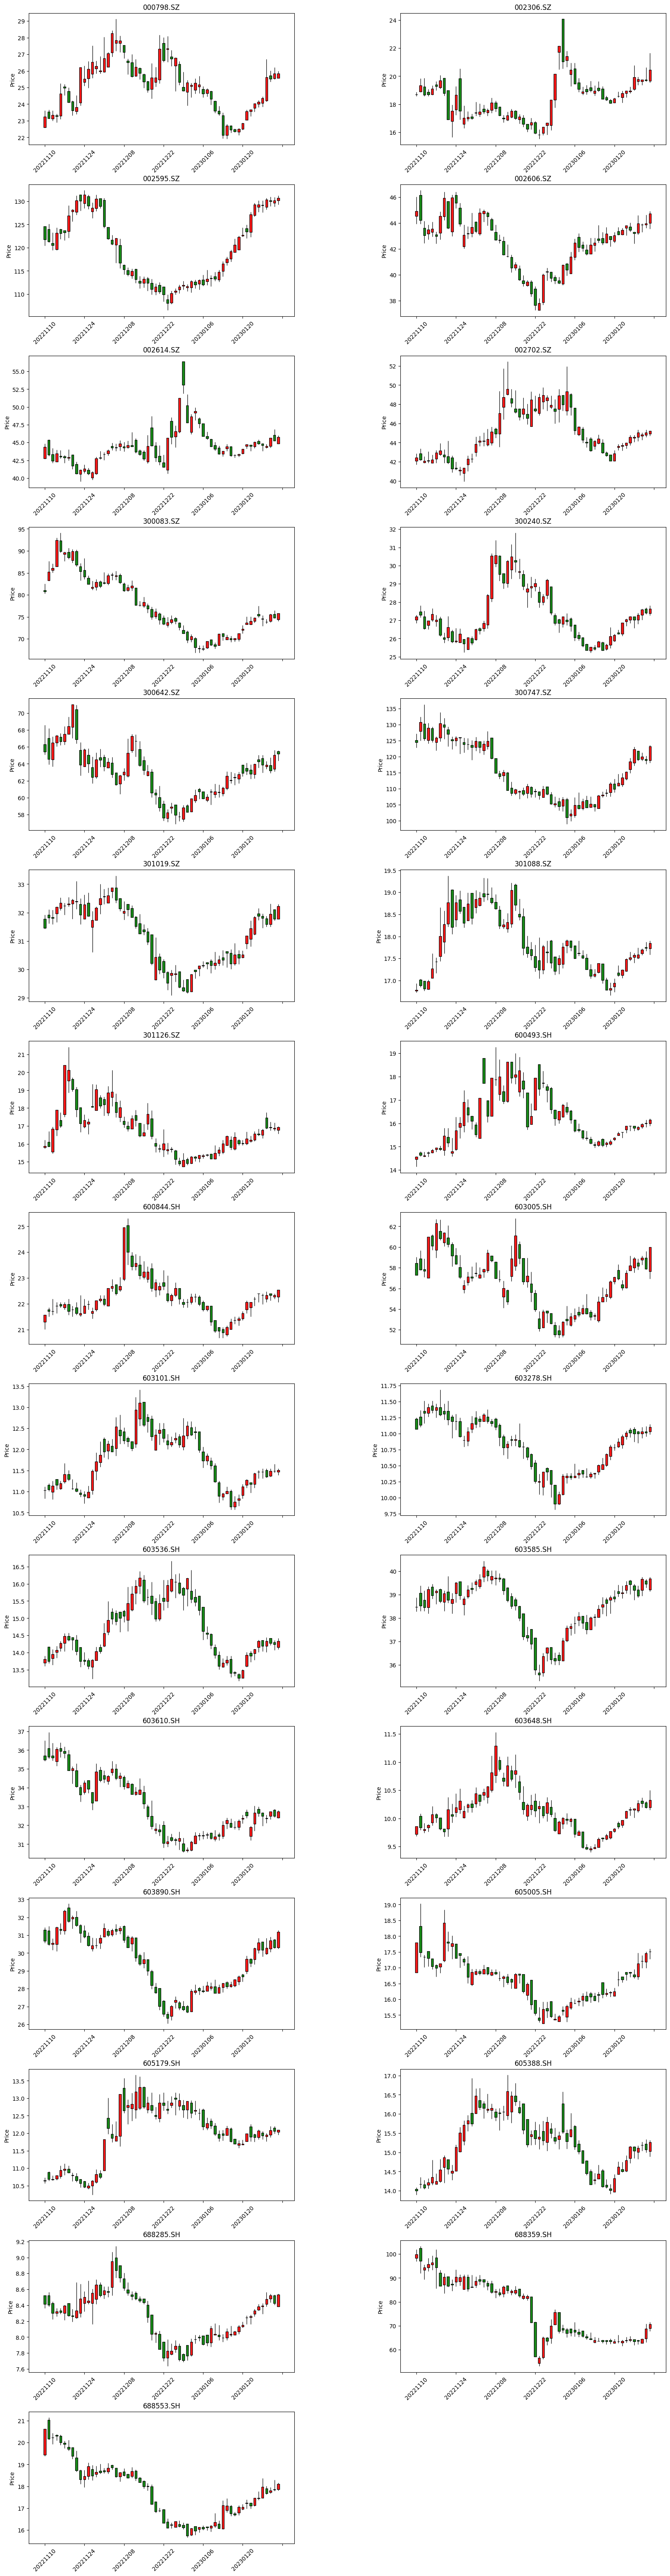

In [92]:
cols:int = 2
size:int = len(codes)
rows:int = size//2 + 1 if size%2 else size/2

view_gride_chart(codes,data,rows=rows,cols=cols,figsize=(20,rows*5+5))